https://www.kaggle.com/code/jesucristo/1-house-prices-solution-top-1

In [1]:
import numpy as np # linear algebra
import pandas as pd
from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

import os
print(os.listdir("./data"))

['sample_submission.csv', 'test.csv', 'train.csv']


# 数据加载

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [3]:
train.head()

,ID,Price,Date,Postcode,Property Type,Old/New,Property Rights,First address,Secondary Address,Street,Locality,Town/City,District,County,Category Type,Record Status
0,0,670000,2019/1/11 0:00,CM3 4BS,D,N,F,FIR TREE COTTAGE,NaN,NORTH HILL,LITTLE BADDOW,CHELMSFORD,CHELMSFORD,ESSEX,A,A
1,1,200000,2019/1/4 0:00,SS3 9RJ,T,N,F,38,NaN,EAGLE WAY,SHOEBURYNESS,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,A,A
2,2,545000,2019/1/18 0:00,CM3 4UR,D,N,F,9,NaN,LITTLE FIELDS,DANBURY,CHELMSFORD,CHELMSFORD,ESSEX,A,A
3,3,270000,2019/1/11 0:00,SS0 9TY,T,N,F,148,NaN,WESTBOURNE GROVE,NaN,WESTCLIFF-ON-SEA,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,A,A
4,4,367500,2019/1/16 0:00,SS11 7BB,S,N,F,53,NaN,GUERNSEY GARDENS,NaN,WICKFORD,BASILDON,ESSEX,A,A


In [4]:
test.head()

,ID,Date,Postcode,Property Type,Old/New,Property Rights,First address,Secondary Address,Street,Locality,Town/City,District,County,Category Type,Record Status
0,691866,2019/1/4 0:00,N16 6UH,T,N,F,10,NaN,BELFAST ROAD,NaN,LONDON,HACKNEY,GREATER LONDON,B,A
1,691867,2019/1/18 0:00,SW9 9UQ,O,N,F,6,NaN,BELLEFIELDS ROAD,NaN,LONDON,LAMBETH,GREATER LONDON,B,A
2,691868,2019/1/28 0:00,SW6 4EA,O,N,F,29,NaN,WHITTINGSTALL ROAD,NaN,LONDON,HAMMERSMITH AND FULHAM,GREATER LONDON,B,A
3,691869,2019/2/12 0:00,SW17 7LU,S,N,F,25,NaN,BEECHES ROAD,NaN,LONDON,WANDSWORTH,GREATER LONDON,B,A
4,691870,2019/2/12 0:00,E1 1NU,O,N,F,108,NaN,COMMERCIAL ROAD,NaN,LONDON,TOWER HAMLETS,GREATER LONDON,B,A


In [5]:
print ("Train: ",train.shape[0],"sales, and ",train.shape[1],"features")
print ("Test: ",test.shape[0],"sales, and ",test.shape[1],"features")

Train:  691866 sales, and  16 features
Test:  172967 sales, and  15 features


# 特征分析

邮政编码

属性类型

旧/新

产权

第一个地址

二次地址

街

位置

城市/城市

区

县
类别类型

记录状态

In [6]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']  # 数值特征
# quantitative.remove('Price')
# quantitative.remove('ID')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']  # 分类特征

In [7]:
quantitative

['ID', 'Price']

In [8]:
qualitative

['Date ',
 'Postcode',
 'Property Type',
 'Old/New',
 'Property Rights',
 'First address',
 'Secondary Address',
 'Street',
 'Locality',
 'Town/City',
 'District',
 'County',
 'Category Type',
 'Record Status ']

In [9]:
quantitative.remove('Price')
quantitative.remove('ID')
quantitative

[]

哇，全是分类

## 康康缺失值情况

<Axes: >

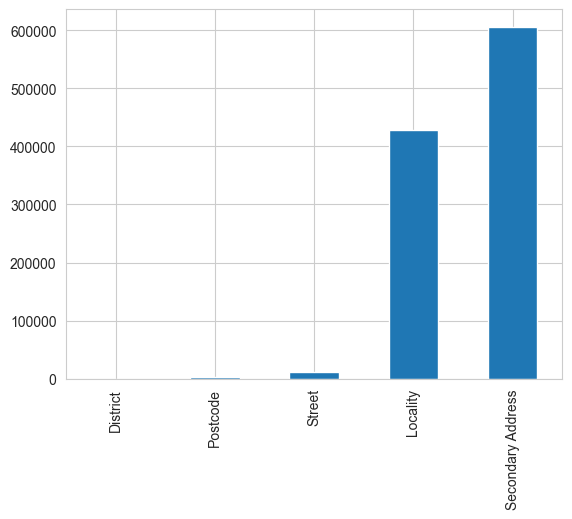

In [10]:
sns.set_style("whitegrid")
missing = train.isnull().sum()  # 计算训练数据集(train)中每个特征列的缺失值数量
missing = missing[missing > 0]  # 选择缺失值数量大于0的特征列
missing.sort_values(inplace=True)  # 按照缺失值数量从小到大排序
missing.plot.bar()

In [11]:
missing_value_ratios = train.isnull().mean()
missing_value_ratios = missing_value_ratios[missing_value_ratios > 0]
missing_value_ratios.sort_values(inplace=True)
missing_value_ratios

District             0.000244
Postcode             0.004708
Street               0.018066
Locality             0.619405
Secondary Address    0.875693
dtype: float64

有五个特征有缺失值，其中Locality与Secondary Address的缺失率都超过了百分之60，可以删除

In [12]:
unique_value_counts = train.nunique()
unique_value_counts = unique_value_counts.drop(['Price', 'ID'])
unique_value_counts.sort_values(inplace=True)
unique_value_counts

Record Status             1
Old/New                   2
Property Rights           2
Category Type             2
Property Type             5
County                  113
District                354
Date                    357
Town/City              1143
Secondary Address      7679
Locality              15374
First address         62371
Street               154962
Postcode             425069
dtype: int64

从中可以看出Record Status只有一个值，可以删掉

其中有像Postcode这样分类比较多的特征不能用传统的方式进行编码

# 特征处理

In [13]:
train_id = train['ID']
test_id = train['ID']
train.drop(['ID', 'Record Status '], axis=1, inplace=True)  # 删‘ID’列
test.drop(['ID', 'Record Status '], axis=1, inplace=True)

In [14]:
# temp = pd.DataFrame(train)
# temp.columns
train.columns

Index(['Price', 'Date ', 'Postcode', 'Property Type', 'Old/New',
       'Property Rights', 'First address', 'Secondary Address', 'Street',
       'Locality', 'Town/City', 'District', 'County', 'Category Type'],
      dtype='object')

In [15]:
train.drop(['Secondary Address'], axis=1, inplace=True)  # 删‘Secondary Address’列
test.drop(['Secondary Address'], axis=1, inplace=True)
train.drop(['Locality'], axis=1, inplace=True)  # 删‘Locality’列
test.drop(['Locality'], axis=1, inplace=True)

In [16]:
train.columns

Index(['Price', 'Date ', 'Postcode', 'Property Type', 'Old/New',
       'Property Rights', 'First address', 'Street', 'Town/City', 'District',
       'County', 'Category Type'],
      dtype='object')

# 使用众数填充缺失值

In [17]:
train['Postcode'].fillna(train['Postcode'].mode()[0], inplace=True)
test['Postcode'].fillna(test['Postcode'].mode()[0], inplace=True)

train['Street'].fillna(train['Street'].mode()[0], inplace=True)
test['Street'].fillna(test['Street'].mode()[0], inplace=True)

train['District'].fillna(train['District'].mode()[0], inplace=True)
test['District'].fillna(test['District'].mode()[0], inplace=True)

In [18]:
train_missing_after = train.isnull().sum()
test_missing_after = test.isnull().sum()

In [19]:
train_missing_after

Price              0
Date               0
Postcode           0
Property Type      0
Old/New            0
Property Rights    0
First address      0
Street             0
Town/City          0
District           0
County             0
Category Type      0
dtype: int64

In [20]:
test_missing_after

Date               0
Postcode           0
Property Type      0
Old/New            0
Property Rights    0
First address      0
Street             0
Town/City          0
District           0
County             0
Category Type      0
dtype: int64

# 对Price做log变换

In [21]:
train['Price_log'] = np.log1p(train['Price'])

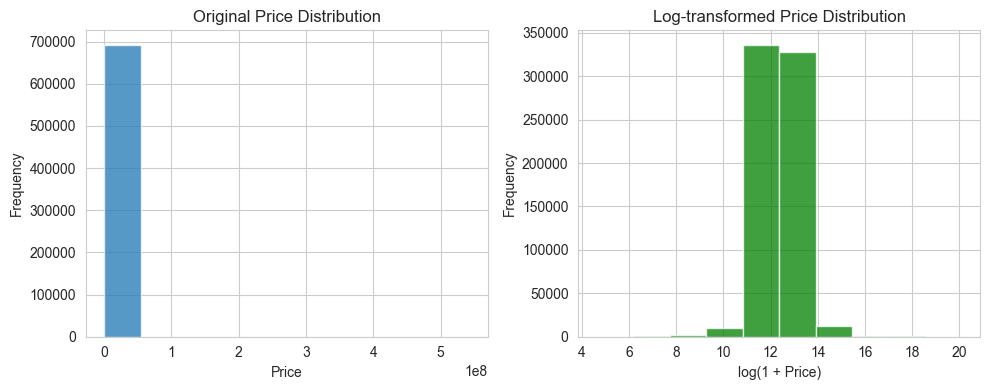

In [22]:
# 创建一个 1x2 的子图布局
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# 绘制原始价格数据的直方图
axes[0].hist(train['Price'], bins=10, alpha=0.75)
axes[0].set_title('Original Price Distribution')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')

# 绘制对数变换后的价格数据的直方图
axes[1].hist(train['Price_log'], bins=10, alpha=0.75, color='g')
axes[1].set_title('Log-transformed Price Distribution')
axes[1].set_xlabel('log(1 + Price)')
axes[1].set_ylabel('Frequency')

# 显示图形
plt.tight_layout()
plt.show()

In [23]:
train['Price'] = np.log1p(train['Price'])

In [24]:
train.columns

Index(['Price', 'Date ', 'Postcode', 'Property Type', 'Old/New',
       'Property Rights', 'First address', 'Street', 'Town/City', 'District',
       'County', 'Category Type', 'Price_log'],
      dtype='object')

In [25]:
train.drop(['Price_log'], axis=1, inplace=True)

In [26]:
train.columns

Index(['Price', 'Date ', 'Postcode', 'Property Type', 'Old/New',
       'Property Rights', 'First address', 'Street', 'Town/City', 'District',
       'County', 'Category Type'],
      dtype='object')

#  合并

In [27]:
train_counts = train.shape[0]
test_counts = test.shape[0]

train_Price = train['Price'][:train_counts]
train_features = train.drop(['Price'], axis=1)
test_features = test
features = pd.concat([train_features, test_features]).reset_index(drop=True)

In [28]:
features.shape

(864833, 11)

# Date

date特征相对于其他特征来说比较复杂，得好好处理

将其处理成'Month'和'Day'特征。

对于'Month'特征，我们可以将其转换为季节信息，以反映季节性因素对房价的影响。例如，我们可以将'Winter'、'Spring'、'Summer'和'Fall'等季节信息作为新的特征进行建模。

对于'Day'特征，我们可以将其转换为星期几信息，以反映周末和工作日对房价的影响。例如，我们可以将'Weekday'和'Weekend'等星期几信息作为新的特征进行建模。

In [29]:
features.head()

,Date,Postcode,Property Type,Old/New,Property Rights,First address,Street,Town/City,District,County,Category Type
0,2019/1/11 0:00,CM3 4BS,D,N,F,FIR TREE COTTAGE,NORTH HILL,CHELMSFORD,CHELMSFORD,ESSEX,A
1,2019/1/4 0:00,SS3 9RJ,T,N,F,38,EAGLE WAY,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,A
2,2019/1/18 0:00,CM3 4UR,D,N,F,9,LITTLE FIELDS,CHELMSFORD,CHELMSFORD,ESSEX,A
3,2019/1/11 0:00,SS0 9TY,T,N,F,148,WESTBOURNE GROVE,WESTCLIFF-ON-SEA,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,A
4,2019/1/16 0:00,SS11 7BB,S,N,F,53,GUERNSEY GARDENS,WICKFORD,BASILDON,ESSEX,A


In [30]:
features['Date '] = pd.to_datetime(features['Date '])

# 提取月、日新特征
features['Month'] = features['Date '].dt.month
features['Day'] = features['Date '].dt.day

在新特征'Month'和'Day'中，我们可以考虑进一步提取有用的信息

对于'Month'特征，我们可以将其转换为季节信息，以反映季节性因素对房价的影响。例如，我们可以将'Winter'、'Spring'、'Summer'和'Fall'等季节信息作为新的特征进行建模。

对于'Day'特征，我们可以将其转换为星期几信息，以反映周末和工作日对房价的影响。例如，我们可以将'Weekday'和'Weekend'等星期几信息作为新的特征进行建模。

In [31]:
features.head()

,Date,Postcode,Property Type,Old/New,Property Rights,First address,Street,Town/City,District,County,Category Type,Month,Day
0,2019-01-11,CM3 4BS,D,N,F,FIR TREE COTTAGE,NORTH HILL,CHELMSFORD,CHELMSFORD,ESSEX,A,1,11
1,2019-01-04,SS3 9RJ,T,N,F,38,EAGLE WAY,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,A,1,4
2,2019-01-18,CM3 4UR,D,N,F,9,LITTLE FIELDS,CHELMSFORD,CHELMSFORD,ESSEX,A,1,18
3,2019-01-11,SS0 9TY,T,N,F,148,WESTBOURNE GROVE,WESTCLIFF-ON-SEA,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,A,1,11
4,2019-01-16,SS11 7BB,S,N,F,53,GUERNSEY GARDENS,WICKFORD,BASILDON,ESSEX,A,1,16


In [32]:
# 提取'Month'特征，转换为季节信息
seasons = [(1, 'Winter'), (4, 'Spring'), (7, 'Summer'), (10, 'Fall')]
bins = [1, 4, 7, 10, 13]
labels = [name for _, name in seasons]
features['Season'] = pd.cut(features['Date '].dt.month, bins=bins, labels=labels, right=False)

# 提取'Day'特征，转换为星期几信息
features['Weekday'] = features['Date '].dt.weekday
features['Weekend'] = features['Weekday'].isin([5, 6]).astype(int)

In [33]:
features.head()

,Date,Postcode,Property Type,Old/New,Property Rights,First address,Street,Town/City,District,County,Category Type,Month,Day,Season,Weekday,Weekend
0,2019-01-11,CM3 4BS,D,N,F,FIR TREE COTTAGE,NORTH HILL,CHELMSFORD,CHELMSFORD,ESSEX,A,1,11,Winter,4,0
1,2019-01-04,SS3 9RJ,T,N,F,38,EAGLE WAY,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,A,1,4,Winter,4,0
2,2019-01-18,CM3 4UR,D,N,F,9,LITTLE FIELDS,CHELMSFORD,CHELMSFORD,ESSEX,A,1,18,Winter,4,0
3,2019-01-11,SS0 9TY,T,N,F,148,WESTBOURNE GROVE,WESTCLIFF-ON-SEA,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,A,1,11,Winter,4,0
4,2019-01-16,SS11 7BB,S,N,F,53,GUERNSEY GARDENS,WICKFORD,BASILDON,ESSEX,A,1,16,Winter,2,0


In [34]:
# 删除原始的'Date '列
features.drop(['Date '], axis=1, inplace=True)

In [35]:
features.head()

,Postcode,Property Type,Old/New,Property Rights,First address,Street,Town/City,District,County,Category Type,Month,Day,Season,Weekday,Weekend
0,CM3 4BS,D,N,F,FIR TREE COTTAGE,NORTH HILL,CHELMSFORD,CHELMSFORD,ESSEX,A,1,11,Winter,4,0
1,SS3 9RJ,T,N,F,38,EAGLE WAY,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,A,1,4,Winter,4,0
2,CM3 4UR,D,N,F,9,LITTLE FIELDS,CHELMSFORD,CHELMSFORD,ESSEX,A,1,18,Winter,4,0
3,SS0 9TY,T,N,F,148,WESTBOURNE GROVE,WESTCLIFF-ON-SEA,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,A,1,11,Winter,4,0
4,SS11 7BB,S,N,F,53,GUERNSEY GARDENS,WICKFORD,BASILDON,ESSEX,A,1,16,Winter,2,0


In [36]:
features_unique_value_counts = features.nunique()
features_unique_value_counts.sort_values(inplace=True)
features_unique_value_counts

Old/New                 2
Property Rights         2
Category Type           2
Weekend                 2
Season                  4
Property Type           5
Weekday                 7
Month                  12
Day                    31
County                113
District              354
Town/City            1145
First address       72904
Street             170366
Postcode           492837
dtype: int64

# 均值编码

In [37]:
from mean_encoder import MeanEncoder

Large_Num_Features = ['Postcode', 'Street', 'First address', 'Town/City', 'District', 'County']

mean_encoder = MeanEncoder(categorical_features=Large_Num_Features)
train = mean_encoder.fit_transform(train, train['Price'])
features = mean_encoder.transform(features)

features.drop(Large_Num_Features, axis=1, inplace=True)

            Price           Date   Postcode Property Type Old/New  \
0       13.415034  2019/1/11 0:00   CM3 4BS             D       N   
1       12.206078   2019/1/4 0:00   SS3 9RJ             T       N   
2       13.208543  2019/1/18 0:00   CM3 4UR             D       N   
3       12.506181  2019/1/11 0:00   SS0 9TY             T       N   
4       12.814481  2019/1/16 0:00  SS11 7BB             S       N   
...           ...             ...       ...           ...     ...   
691861  13.304687  2019/1/15 0:00  SW15 2TR             O       N   
691862  14.603968   2019/1/3 0:00  EC2A 4HB             O       N   
691863  13.473022   2019/2/1 0:00   SW9 9JB             T       N   
691864  14.058458  2019/1/25 0:00    E8 4AU             O       N   
691865  14.077876  2019/2/22 0:00  SW12 0BH             T       N   

       Property Rights       First address               Street  \
0                    F    FIR TREE COTTAGE           NORTH HILL   
1                    F               

Town/City
ABBOTS LANGLEY     1.979260e-32
ABERAERON          2.543666e-13
ABERDARE          1.746409e-177
ABERDOVEY          1.026188e-10
ABERGAVENNY       3.961430e-107
                      ...      
YATELEY            6.813557e-46
YELVERTON          7.667648e-53
YEOVIL            6.308650e-287
YORK               0.000000e+00
YSTRAD MEURIG      1.670142e-05
Name: beta, Length: 1143, dtype: float64
(553493,) (138373,)
Town/City
ABBOTS LANGLEY     7.281290e-33
ABERAERON          4.658886e-15
ABERDARE          3.507755e-176
ABERDOVEY          2.543666e-13
ABERGAVENNY       1.798486e-111
                      ...      
YATELEY            5.166421e-55
YELVERTON          2.138866e-62
YEOVIL             0.000000e+00
YORK               0.000000e+00
YSTRAD MEURIG      8.315280e-07
Name: beta, Length: 1143, dtype: float64
(553493,) (138373,)
Town/City
ABBOTS LANGLEY     9.602680e-24
ABERAERON          6.305117e-16
ABERDARE          2.659777e-185
ABERDOVEY          1.026188e-10
ABERGAVENNY     

In [38]:
features.columns

Index(['Property Type', 'Old/New', 'Property Rights', 'Category Type', 'Month',
       'Day', 'Season', 'Weekday', 'Weekend', 'Postcode_pred', 'Street_pred',
       'First address_pred', 'Town/City_pred', 'District_pred', 'County_pred'],
      dtype='object')

In [39]:
features.head()

,Property Type,Old/New,Property Rights,Category Type,Month,Day,Season,Weekday,Weekend,Postcode_pred,Street_pred,First address_pred,Town/City_pred,District_pred,County_pred
0,D,N,F,A,1,11,Winter,4,0,12.575382,12.836416,12.730543,12.751106,12.760198,12.648644
1,T,N,F,A,1,4,Winter,4,0,12.317380,12.491972,12.267077,12.426871,12.471634,12.471634
2,D,N,F,A,1,18,Winter,4,0,12.530954,12.530954,12.321913,12.751106,12.760198,12.648644
3,T,N,F,A,1,11,Winter,4,0,12.516533,12.301891,12.248284,12.352119,12.471634,12.471634
4,S,N,F,A,1,16,Winter,2,0,12.446171,12.446171,12.285332,12.703646,12.616049,12.648644


# 标签编码

In [40]:
from sklearn.preprocessing import LabelEncoder

# 创建LabelEncoder对象
le = LabelEncoder()
features['Property Type'] = le.fit_transform(features['Property Type'])
features['Old/New'] = le.fit_transform(features['Old/New'])
features['Property Rights'] = le.fit_transform(features['Property Rights'])

In [41]:
features.head()

,Property Type,Old/New,Property Rights,Category Type,Month,Day,Season,Weekday,Weekend,Postcode_pred,Street_pred,First address_pred,Town/City_pred,District_pred,County_pred
0,0,0,0,A,1,11,Winter,4,0,12.575382,12.836416,12.730543,12.751106,12.760198,12.648644
1,4,0,0,A,1,4,Winter,4,0,12.317380,12.491972,12.267077,12.426871,12.471634,12.471634
2,0,0,0,A,1,18,Winter,4,0,12.530954,12.530954,12.321913,12.751106,12.760198,12.648644
3,4,0,0,A,1,11,Winter,4,0,12.516533,12.301891,12.248284,12.352119,12.471634,12.471634
4,3,0,0,A,1,16,Winter,2,0,12.446171,12.446171,12.285332,12.703646,12.616049,12.648644


# 独热编码

In [42]:
features = pd.get_dummies(features, columns=['Category Type'])
features['Category Type_A'] = features['Category Type_A'].astype('int8')
features['Category Type_B'] = features['Category Type_B'].astype('int8')
features = pd.get_dummies(features, columns=['Season'])
features['Season_Spring'] = features['Season_Spring'].astype('int8')
features['Season_Summer'] = features['Season_Summer'].astype('int8')
features['Season_Fall'] = features['Season_Fall'].astype('int8')
features['Season_Winter'] = features['Season_Winter'].astype('int8')

In [43]:
train = features[:train_counts]
test = features[train_counts:]

In [44]:
train.head()

,Property Type,Old/New,Property Rights,Month,Day,Weekday,Weekend,Postcode_pred,Street_pred,First address_pred,Town/City_pred,District_pred,County_pred,Category Type_A,Category Type_B,Season_Winter,Season_Spring,Season_Summer,Season_Fall
0,0,0,0,1,11,4,0,12.575382,12.836416,12.730543,12.751106,12.760198,12.648644,1,0,1,0,0,0
1,4,0,0,1,4,4,0,12.317380,12.491972,12.267077,12.426871,12.471634,12.471634,1,0,1,0,0,0
2,0,0,0,1,18,4,0,12.530954,12.530954,12.321913,12.751106,12.760198,12.648644,1,0,1,0,0,0
3,4,0,0,1,11,4,0,12.516533,12.301891,12.248284,12.352119,12.471634,12.471634,1,0,1,0,0,0
4,3,0,0,1,16,2,0,12.446171,12.446171,12.285332,12.703646,12.616049,12.648644,1,0,1,0,0,0


In [45]:
test.head()

,Property Type,Old/New,Property Rights,Month,Day,Weekday,Weekend,Postcode_pred,Street_pred,First address_pred,Town/City_pred,District_pred,County_pred,Category Type_A,Category Type_B,Season_Winter,Season_Spring,Season_Summer,Season_Fall
691866,4,0,0,1,4,4,0,12.756831,12.799811,12.327445,13.190516,13.228301,13.058776,0,1,1,0,0,0
691867,2,0,0,1,18,4,0,12.551678,12.551678,12.335350,13.190516,13.161855,13.058776,0,1,1,0,0,0
691868,2,0,0,1,28,0,0,12.986928,13.186871,12.273475,13.190516,13.461303,13.058776,0,1,1,0,0,0
691869,3,0,0,2,12,1,0,12.345351,12.125896,12.282290,13.190516,13.300139,13.058776,0,1,1,0,0,0
691870,2,0,0,2,12,1,0,12.345351,11.988455,12.288258,13.190516,13.056769,13.058776,0,1,1,0,0,0


# 机器学习

In [46]:
X_train = train
y_train = train_Price

In [47]:
X_train

,Property Type,Old/New,Property Rights,Month,Day,Weekday,Weekend,Postcode_pred,Street_pred,First address_pred,Town/City_pred,District_pred,County_pred,Category Type_A,Category Type_B,Season_Winter,Season_Spring,Season_Summer,Season_Fall
0,0,0,0,1,11,4,0,12.575382,12.836416,12.730543,12.751106,12.760198,12.648644,1,0,1,0,0,0
1,4,0,0,1,4,4,0,12.317380,12.491972,12.267077,12.426871,12.471634,12.471634,1,0,1,0,0,0
2,0,0,0,1,18,4,0,12.530954,12.530954,12.321913,12.751106,12.760198,12.648644,1,0,1,0,0,0
3,4,0,0,1,11,4,0,12.516533,12.301891,12.248284,12.352119,12.471634,12.471634,1,0,1,0,0,0
4,3,0,0,1,16,2,0,12.446171,12.446171,12.285332,12.703646,12.616049,12.648644,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691861,2,0,0,1,15,1,0,12.552833,13.115023,12.552833,13.190516,13.300139,13.058776,0,1,1,0,0,0
691862,2,0,0,1,3,3,0,12.832378,11.865432,12.264185,13.190516,13.228301,13.058776,0,1,1,0,0,0
691863,4,0,0,2,1,4,0,12.589051,12.617600,12.270346,13.190516,13.161855,13.058776,0,1,1,0,0,0
691864,2,0,0,1,25,4,0,13.152776,12.414155,12.220114,13.190516,13.228301,13.058776,0,1,1,0,0,0


In [48]:
y_train

0         13.415034
1         12.206078
2         13.208543
3         12.506181
4         12.814481
            ...    
691861    13.304687
691862    14.603968
691863    13.473022
691864    14.058458
691865    14.077876
Name: Price, Length: 691866, dtype: float64

In [49]:
train.values

array([[0., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [4., 0., 0., ..., 0., 0., 0.],
       [2., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.]])

## 评价函数

In [50]:
from sklearn.model_selection import cross_val_predict
#采用十折交叉验证
n_folds = 10

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=20)
    preds = cross_val_predict(model, X_train, y_train, cv=kf)
    rmsle = np.sqrt(mean_squared_error(y_train, preds))
    return (rmsle)

In [51]:
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 691866 entries, 0 to 691865
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Property Type       691866 non-null  int32  
 1   Old/New             691866 non-null  int32  
 2   Property Rights     691866 non-null  int32  
 3   Month               691866 non-null  int32  
 4   Day                 691866 non-null  int32  
 5   Weekday             691866 non-null  int32  
 6   Weekend             691866 non-null  int32  
 7   Postcode_pred       691866 non-null  float64
 8   Street_pred         691866 non-null  float64
 9   First address_pred  691866 non-null  float64
 10  Town/City_pred      691866 non-null  float64
 11  District_pred       691866 non-null  float64
 12  County_pred         691866 non-null  float64
 13  Category Type_A     691866 non-null  int8   
 14  Category Type_B     691866 non-null  int8   
 15  Season_Winter       691866 non-nul

In [52]:
print(X_train[X_train.isna().any(axis=1)])

Empty DataFrame
Columns: [Property Type, Old/New, Property Rights, Month, Day, Weekday, Weekend, Postcode_pred, Street_pred, First address_pred, Town/City_pred, District_pred, County_pred, Category Type_A, Category Type_B, Season_Winter, Season_Spring, Season_Summer, Season_Fall]
Index: []


In [53]:
#LightGBM
lgbr_params = {'learning_rate': 0.005,
               'n_estimators': 500, 
               'max_depth': 6,
               'num_leaves': 30,
               'subsample': 0.8,
               'colsample_bytree': 0.8,
               'min_child_weight': 0.001,
               'min_child_samples': 25,
               'random_state': 42,
               'reg_alpha': 0.01,
               'boosting_type': 'gbdt',
               'histogram_pool_size': 2048,
               'reg_lambda': 0.05}
lgbr = LGBMRegressor(**lgbr_params)

#XGBoost
xgbr_params = {'learning_rate': 0.005,
               'n_estimators': 8000,
               'tree_method': 'gpu_hist',
               'max_depth': 9,
               'subsample': 0.8,
               'colsample_bytree': 0.8,
               'min_child_weight': 5,
               'seed': 42,
               'gamma': 0.1,
               'reg_alpha': 0.1,
               'reg_lambda': 0.1,
               'n_jobs': -1}
xgbr = XGBRegressor(**xgbr_params)

# histGBR
from sklearn.ensemble import HistGradientBoostingRegressor
gbr_params = {'loss': 'squared_error', 
              'max_iter': 600, 
              'learning_rate': 0.005, 
              'max_depth': 8, 
              'max_leaf_nodes': 1000, 
              'random_state': 42}

gbr = HistGradientBoostingRegressor(**gbr_params)

## 基本模型效果评价

In [54]:
models_name = ['HistGBR', 'LightGBM', 'XGBoost']
models = [gbr, lgbr, xgbr]
for i, model in enumerate(models):
  score = rmsle_cv(model)
  print('{} score: {}({})'.format(models_name[i], score.mean(), score.std()))

HistGBR score: 0.3038770522232972(0.0)
LightGBM score: 0.3392898070317509(0.0)
XGBoost score: 0.6882178189920776(0.0)


In [55]:
stack_model = StackingCVRegressor(regressors=(gbr, lgbr, xgbr),
                                  meta_regressor=gbr, use_features_in_secondary=True)

# 在整个训练集上训练各个模型

In [56]:
#Gradient Boosting
gbr_trained = gbr.fit(np.array(X_train), np.array(y_train))

#LightGBM
lgbr_trained = lgbr.fit(np.array(X_train), np.array(y_train))

#XGBoost
xgbr_trained = xgbr.fit(np.array(X_train), np.array(y_train))

#Stacking
stack_model_trained = stack_model.fit(np.array(X_train), np.array(y_train))

## 评估各个模型在训练集上的表现

In [57]:
from sklearn.metrics import mean_absolute_error

def rmsle(y, y_preds):
  return mean_absolute_error(y, y_preds)

In [58]:
models.append(stack_model)
models_name.append('Stacking_model')
for i, model in enumerate(models):
  y_preds = model.predict(np.array(X_train))
  model_score = rmsle(y_train, y_preds)
  print('RMSE of {}: {}'.format(models_name[i], model_score))

RMSE of HistGBR: 0.18381811604200274
RMSE of LightGBM: 0.20619543525866282
RMSE of XGBoost: 0.6152271637878786
RMSE of Stacking_model: 0.17811656574571122


In [59]:
sample_submission = pd.read_csv('./data/sample_submission.csv')
for i, model in enumerate(models):
  preds = model.predict(np.array(test))
  submission = pd.DataFrame({'ID': sample_submission['ID'], 'Price': np.expm1(preds)})
  submission.to_csv('House_Price_submission_'+models_name[i]+'_optimation.csv', index=False)
  print('{} finished.'.format(models_name[i]))

HistGBR finished.
LightGBM finished.
XGBoost finished.
Stacking_model finished.


In [60]:
#均值融合
preds_in_train = np.zeros((len(y_train), len(models)))
for i, model in enumerate(models):
  preds_in_train[:, i] = model.predict(np.array(X_train))
average_preds_in_train = preds_in_train.mean(axis=1)
average_score = rmsle(y_train, average_preds_in_train)
print('RMSE of average model on training data:', average_score)

RMSE of average model on training data: 0.23873206305987527


In [61]:
#提交均值融合预测结果
preds_in_test = np.zeros((len(test), len(models)))
for i, model in enumerate(models):
  preds_in_test[:, i] = model.predict(np.array(test))
average_preds_in_test = preds_in_test.mean(axis=1)

average_submission = pd.DataFrame({'ID': sample_submission['ID'], 'Price': np.expm1(average_preds_in_test)})
average_submission.to_csv('House_Price_submission_average_model_optimation.csv', index=False)

In [62]:
train.shape[1]

19